<a href="https://colab.research.google.com/github/todnewman/coe_training/blob/master/NLP_word2vec_demonstration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Word2Vec Demonstration

**Author**: W. Tod Newman

**Updates**: First Revision

## Learning Objectives


*  Understand how to develop tools to identify word similarity
*  Understand some use cases where this can be helpful
*  Evaluate different ways of visualizing these results, including PCA and t-SNE
*  Evaluate how unsupervised approaches like k-means can cluster word groupings

## Data
In this exercise we're using data from sklearn's open data repository called the 20 Newsgroup Dataset.  We have details below on this dataset.

## Overview

Word2Vec is one of many different word embedding techniques. Right now, word embedding is one of the most popular ways to represent the vocabulary in a document or set of documents. 

So, what is word embedding? Word embedding is a vector representation of a word. For example, let's consider the folling three phases:

    Jerry is a dog.
    Molly is also a dog.
    Dog is man's best friend.

The dictionary of this corpus of text (three phrases) consists of all unique words:

    ["jerry", "molly", dog", "man's", "a", "also", is", "best", "friend"]

A simple vector representation of the word "jerry" would be:

    [1, 0, 0, 0, 0, 0, 0, 0, 0]

where 1 stands for the word "jerry" in our dictionary. This word embedding is called one-hot encoding. For any word, the length of a vector is always 7 in our example, because the dictionary consists of 7 unique words. This word embedding technique is very simple, but has a tremendous disadvantage. Let's take vector representations of two words:

    "jerry" and "dog" -> [1, 0, 0, 0, 0, 0, 0, 0, 0] and [0, 0, 1, 0, 0, 0, 0, 0, 0]

These two vectors provide no useful information regarding the relationships that may exist between the "jerry" and "dog". In other words, the similarity between words is not captured by the one-hot encoding. Loosely speaking, one-hot encoding does not enable the system making conclusions about the word "jerry" given the word "dog" (for example, such that jerry is man's best friend).

Word2Vec is a more sophisticated word embedding technique. This technique is based on the idea that words that occur in the same contexts tend to have similar meanings. From Wikipedia:

* "Word2Vec is a two-layer neural network that takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space" (Wikipedia).


In [0]:
#!pip install gensim
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords
from gensim.test.utils import common_texts, get_tmpfile

## Natural Language Toolkit downloads
We have to download data from the NLTK repo.  This will help us with stemming and removing low information words.

In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Download and Prepare Text Corpus

The 20 Newsgroups dataset is a collection of about 20,000 documents from 20 different newsgroups.  The 20 newsgroups collection has become a popular data set for experiments in text applications of machine learning techniques, such as text classification and text clustering. 

Here are the newsgroups used.

* comp.graphics
* comp.os.ms-windows.misc
* comp.sys.ibm.pc.hardware
* comp.sys.mac.hardware
* comp.windows.x 	rec.autos
* rec.motorcycles
* rec.sport.baseball
* rec.sport.hockey 	
* sci.crypt
* sci.electronics
* sci.med
* sci.space
* misc.forsale 	talk.politics.misc
* talk.politics.guns
* talk.politics.mideast 	talk.religion.misc
* alt.atheism
* soc.religion.christian

In the block below, we do some processing by removing common stopwords (a, and, the, or, and so on).  We do this because they have extremely low information content (Shannon entropy).  Then we stem the words by removing the prefixes and suffixes and thus reducing the word to its word stem.  

Finally we build and train a Word2Vec model using the gensim library.

## Definition of Word2Vec model parameters:

* size: The size means the dimensionality of word vectors. It defines the number of tokens used to represent each word. For example, rake a look at the picture above. The size would be equal to 4 in this example. Each input word would be represented by 4 tokens: King, Queen, Women, Princess. Rule-of-thumb: If a dataset is small, then size should be small too. If a dataset is large, then size should be greater too. It's the question of tuning.

* window: The maximum distance between the target word and its neighboring word. For example, let's take the phrase "agama is a reptile " with 4 words (suppose that we do not exclude the stop words). If window size is 2, then the vector of word "agama" is directly affected by the word "is" and "a". Rule-of-thumb: a smaller window should provide terms that are more related (of course, the exclusion of stop words should be considered).

* min_count: Ignores all words with total frequency lower than this. For example, if the word frequency is extremally low, then this word might be considered as unimportant.

* sg: Selects training algorithm: 1 for Skip-Gram; 0 for CBOW (Continuous Bag of Words).

* workers: The number of worker threads used to train the model.


In [5]:
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import brown, movie_reviews, treebank 
from gensim.models import KeyedVectors
import gensim
import logging
from nltk.stem.lancaster import LancasterStemmer


stemmer = LancasterStemmer()
sents = []


#categories = ['sci.space']

%time newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=41)
print(type(newsgroups_train.data))

news_data = (newsgroups_train.data)
news = ''.join(news_data)


varfile_list = []

sents = sent_tokenize(news)
sents = [stemmer.stem(word.lower()) for word in sents if word not in stopwords.words('english')]
for s in sents:
    words = word_tokenize(s)
    varfile_list.append(words)

print("List of lists. Let's confirm: ", type(varfile_list), " of ", type(varfile_list[0]))
print(len(varfile_list))

model = gensim.models.Word2Vec(varfile_list, size=150, window=5, min_count=2, workers=4)
model.train(sentences=varfile_list, total_examples=len(varfile_list), epochs=model.iter)

# Retrieve the entire list of "words" from the Google Word2Vec model, and write
# these out to text files so we can peruse them.
vocab = list(model.wv.vocab.keys())

fileNum = 1

wordsInVocab = len(vocab)
wordsPerFile = int(100E3)

print(wordsInVocab)

CPU times: user 5.41 s, sys: 2.03 s, total: 7.44 s
Wall time: 10.2 s
<class 'list'>
List of lists. Let's confirm:  <class 'list'>  of  <class 'list'>
179053


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


76992


## Define which words we want to find similarities for.  

Here we're starting with three words that seem to have a very low level of similarity.  These will be the 'seed' words for three large groups of words that ought to all have a low cosine distance to each other.  This will allow us to see how well Word2Vec works later in this exercise.

In [144]:
df_subset = pd.DataFrame()
wanted_words = []
label_arr = []
word_vectors = model.wv
number = 7
flag = False
primary_words = ["money","baseball","camera", "photoshop"]
for w1 in primary_words:
    
    first_wave = model.wv.most_similar(positive=w1, topn=number)
    for word, i in first_wave:        
        label_arr.append(w1)
        wanted_words.append(word)
        #
        # Now for the second round of similarities
        #
        second_wave = model.wv.most_similar(positive=word, topn=number)
        for word, i in second_wave:
            label_arr.append(w1)
            wanted_words.append(word)

df_subset['Label'] = label_arr
df_subset['Word'] = wanted_words

#
#  For each word in our list of words we just created, go into the model and grab the embedding (word_vector)
#
wanted_vocab = dict((k, word_vectors.vocab[k]) for k in wanted_words if k in word_vectors.vocab)

#
#  Build a dictionary to track which primary word each vector was derived from.  This is primarily
#  for visualization.  Then I convert to a DataFrame, which is more useful in Seaborn plots.
#

label_dict = dict(zip(df_subset.Word, df_subset.Label))

df_label = pd.DataFrame.from_dict(label_dict, orient='index', columns=['Label'])
#wanted_vocab

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## t-SNE

t-distributed stochastic neighbor embedding (t-SNE) is a visualization technique that works in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability.  

So this should plot our "wanted_vocab" from above in such a way that words that appear in similar contexts will be near each other.  Take a look at the plot beolw and note how "launch", "lunar", and "orbit" are all close together.



In [152]:
X = model[wanted_vocab] # X is an array of word vectors, each vector containing 150 tokens
tsne_model = TSNE(perplexity=40, n_components=2, init="pca", n_iter=5000, random_state=23)
Y = tsne_model.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


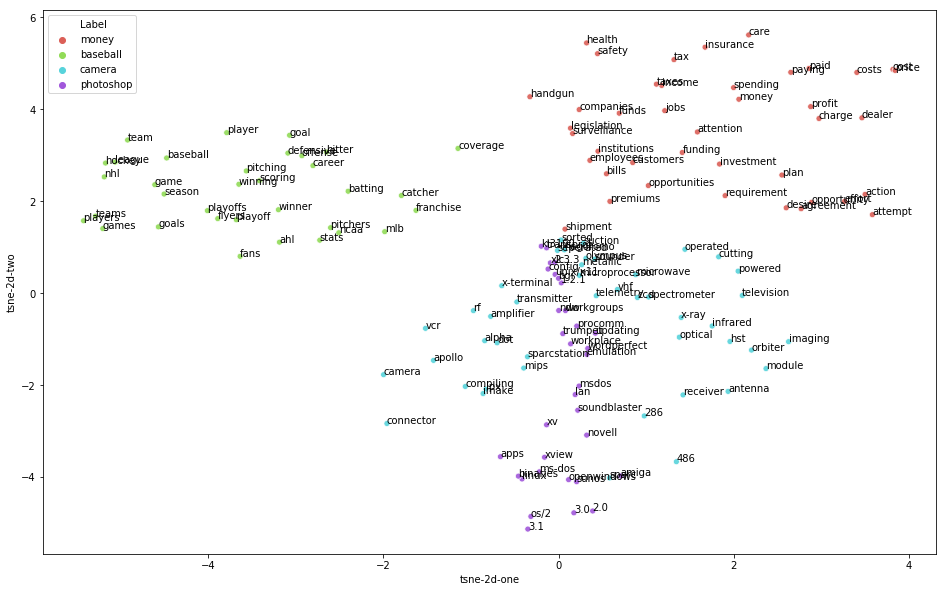

In [153]:
import seaborn as sns
#Plot the t-SNE output
print_text = True

colors = len(primary_words)

df_label['tsne-2d-one'] = Y[:,0]
df_label['tsne-2d-two'] = Y[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Label",
    palette=sns.color_palette("hls", colors),
    data=df_label,
    legend="full",
    alpha=0.9
)
words = list(wanted_vocab)
if print_text:
    for i, word in enumerate(words):
        plt.annotate(word, xy=(Y[i, 0], Y[i, 1]))

## Plot clusters of words along Principal components

Remember when we built the "wanted_words" list we started with three words and then took the 8 most similar words.  Then we took the 8 most similar words to each of those.  In theory, we should have three different clusters of words.

Now we can test to see if k-means can recreate those clusters.

Just for fun, we could try to plot this with 4 clusters just to see how k-Means breaks out the 4th cluster.  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


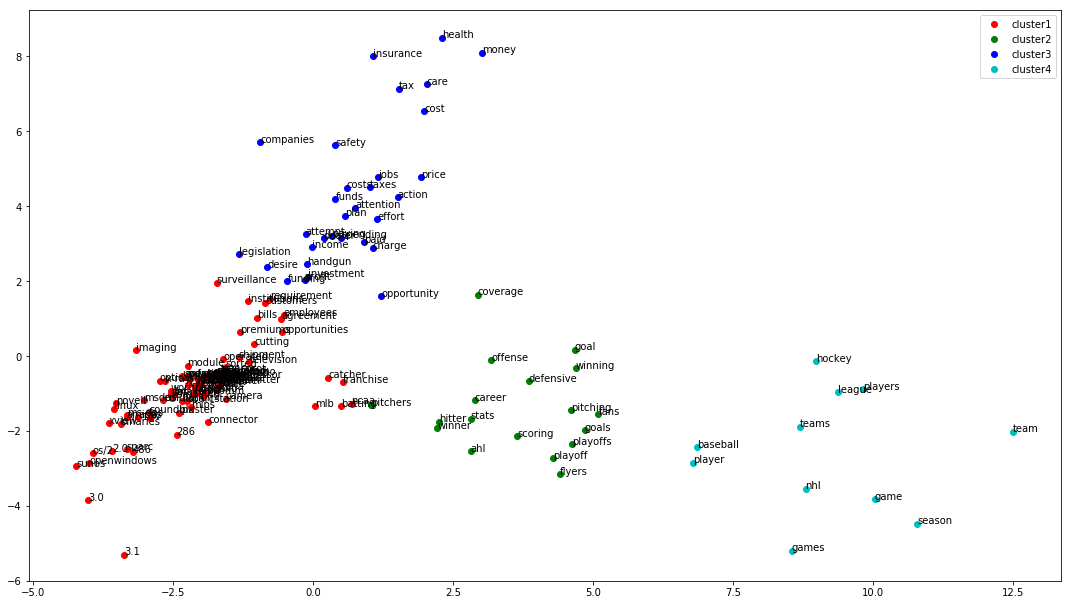

In [151]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from numpy.random import RandomState
from itertools import cycle
import pylab as pl
import matplotlib.pyplot as plt

number_of_clusters = 4

def plot_2D_2(data, target, target_names, datapoint_names):
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    colors = cycle('rgbcmykw')
    target_ids = range(len(target_names))
    for i, c, label in zip(target_ids, colors, target_names):
        ax.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label)
    
    for i, txt in enumerate(datapoint_names):
        ax.annotate(txt, (data[i][0], data[i][1]))
    ax.legend(loc='best')
        
X = model[wanted_vocab]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
kmeans = KMeans(n_clusters=number_of_clusters, random_state=RandomState(42)).fit(X_pca)

words = list(wanted_vocab)
plot_2D_2(X_pca, kmeans.labels_, ["cluster1", "cluster2", "cluster3", 'cluster4'], words)

## PCA with actual Labels below

Above we used K-means to cluster the labels.  Let's see how we did below...



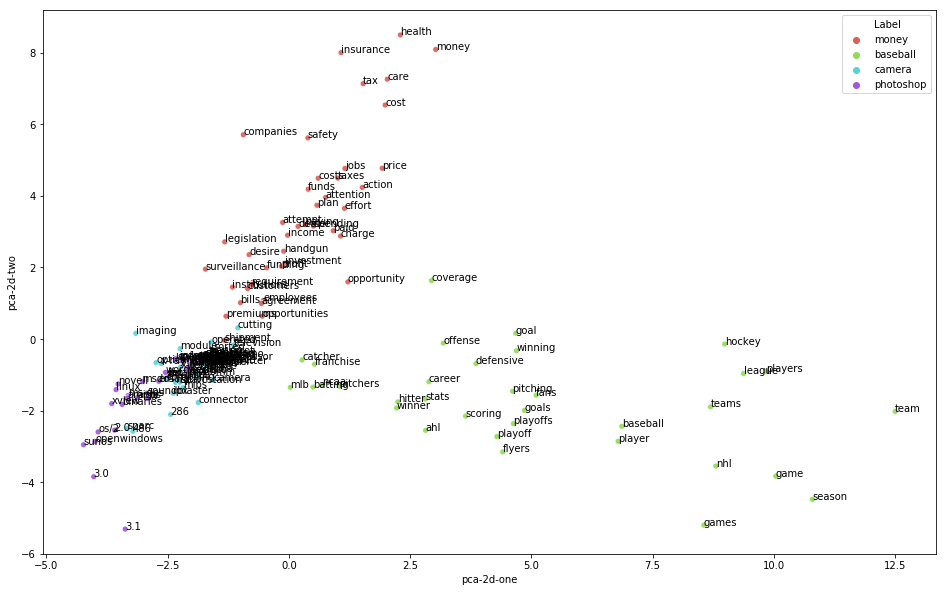

In [148]:
import seaborn as sns
#Plot the t-SNE output

colors = len(primary_words)

df_label['pca-2d-one'] = X_pca[:,0]
df_label['pca-2d-two'] = X_pca[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-2d-one", y="pca-2d-two",
    hue="Label",
    palette=sns.color_palette("hls", colors),
    data=df_label,
    legend="full",
    alpha=0.9
)
words = list(wanted_vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(X_pca[i, 0], X_pca[i, 1]))

## Fun stuff we can do now that we have a Trained Word2Vec Model

In [21]:
w1 = "money"
model.wv.most_similar(positive=w1, topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('tax', 0.5995729565620422),
 ('jobs', 0.5960341691970825),
 ('insurance', 0.5719810128211975),
 ('funds', 0.558326780796051),
 ('attention', 0.5547597408294678)]

This one is funny.  No matter how you parse it, intelligence doesn't match the other two!

In [27]:
model.wv.doesnt_match(["intelligence","republican","democrat"])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'intelligence'

This is interesting.  Not sure how this comes about, but maybe it should make us concerned?

In [23]:
w1 = ["army","prepared"]
w2 = ["shortage"]
model.wv.most_similar (positive=w1,negative=w2,topn=2)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('destroyed', 0.6305720806121826), ('passed', 0.623725414276123)]

Here are a couple to show how sometimes the results are garbage.  When you look for the most dissimilar results to evil, that doesn't mean the opposite necessarily.  A lot of junk words are highly dissimilar and get captured.

In [24]:
model.most_similar('evil')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('fear', 0.6959516406059265),
 ('spirit', 0.6098051071166992),
 ('humanity', 0.5875322222709656),
 ('faith', 0.5869924426078796),
 ('racist', 0.5865370035171509),
 ('punishment', 0.584489643573761),
 ('religion', 0.583932638168335),
 ('gods', 0.583915650844574),
 ('lord', 0.5766323804855347),
 ('deeds', 0.5755507349967957)]

In [25]:
model.most_similar(negative=['evil'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('==============================', 0.5195416808128357),
 ('wangtek', 0.5169981122016907),
 ('last-update', 0.4929322898387909),
 ('video/monitor', 0.4833919107913971),
 ('last-modified', 0.482252299785614),
 ('logicache', 0.4746699333190918),
 ('92', 0.4564031958580017),
 ('r3000', 0.4536125957965851),
 ('archive-name', 0.4532835781574249),
 ('sceptre', 0.4528264105319977)]

Return the similarity percentage

In [26]:
model.similarity('girl', 'woman')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.68466693